In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import utils

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        '''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow version: 2.11.0


"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        "

In [3]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


# Getting total number of image in each category

In [32]:
for expression in os.listdir('/kaggle/input/fer2013/train'):
    print(str(len(os.listdir('/kaggle/input/fer2013/train/'+ expression)))+" "+ expression +" images")

3171 surprise images
4097 fear images
3995 angry images
4965 neutral images
4830 sad images
436 disgust images
7215 happy images


# Generate Training and Validation Batches


In [33]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory('/kaggle/input/fer2013/train/',
                                                 target_size=(img_size,img_size),
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True
                                                )
datagen_validation=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_train.flow_from_directory('/kaggle/input/fer2013/test/',
                                                 target_size=(img_size,img_size),
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True
                                                )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Create CNN Architecture

In [34]:
# Initialising the CNN
model=Sequential()
# 1 convolution
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add( MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 convolution
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add( MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 3 convolution
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add( MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Flattenting 
model.add(Flatten())
          
#fully connected 1 layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
#fully connected 2 layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
          
model.add(Dense(7,activation='softmax'))
opt=Adam(lr=0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)      

# Training and Evaluating Model

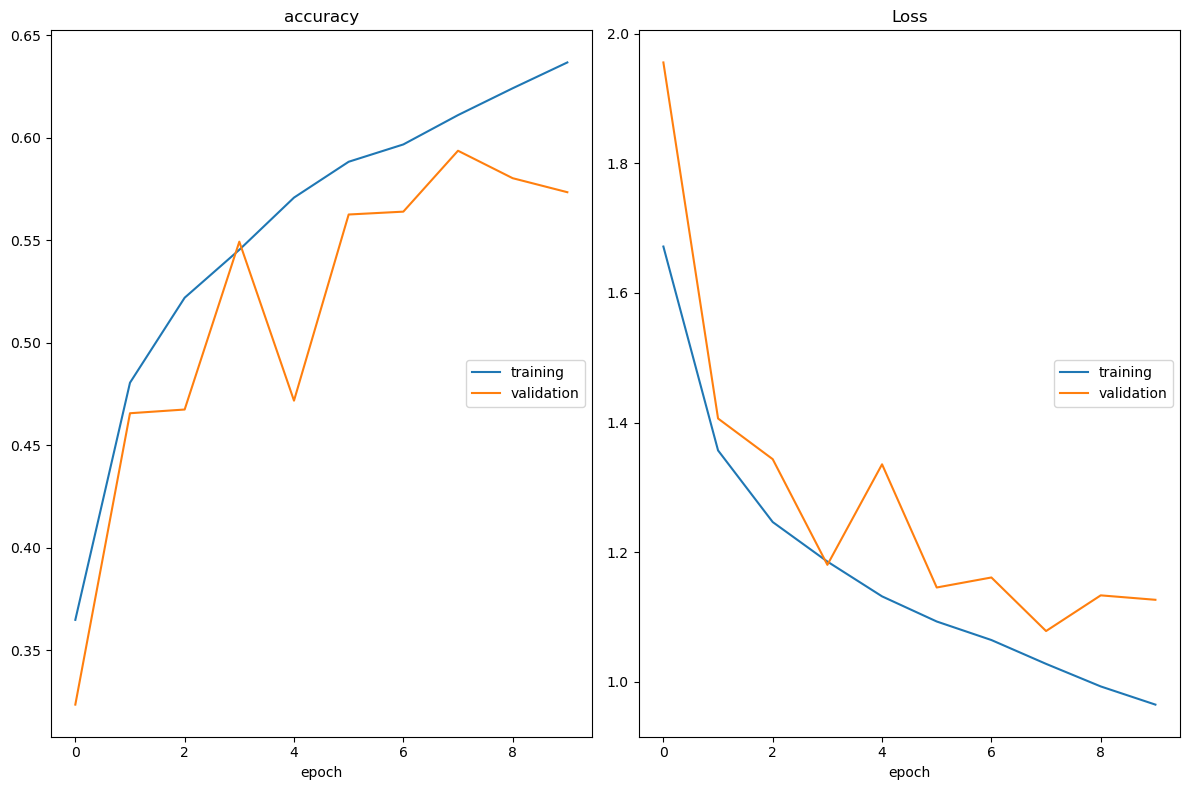

accuracy
	training         	 (min:    0.365, max:    0.637, cur:    0.637)
	validation       	 (min:    0.323, max:    0.594, cur:    0.573)
Loss
	training         	 (min:    0.965, max:    1.672, cur:    0.965)
	validation       	 (min:    1.078, max:    1.956, cur:    1.126)

Epoch 10: saving model to model_weights.h5
448/448 [==============================] - 35s 77ms/step - loss: 0.9646 - accuracy: 0.6367 - val_loss: 1.1264 - val_accuracy: 0.5734 - lr: 0.0010


In [35]:
epoch=10
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,mode='auto')
checkpoint= ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                           save_weights_only=True, mode='max', verbose=1)
callbacks=[PlotLossesCallback(),reduce_lr,checkpoint]
history=model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoch,
    validation_data = validation_generator,
    callbacks=callbacks,
    validation_steps = validation_steps
)

In [38]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 7s 61ms/step - loss: 1.1227 - accuracy: 0.5748
final train accuracy = 66.34 , validation accuracy = 57.48


# Represent Model as JSON String 

In [20]:
model_json = model.to_json()
model.save_weights('model_weights.h5')
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# class for Loading model and Weights 

In [24]:
from tensorflow.keras.models import model_from_json
class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

# Getting Frame and Doing Prediction

In [25]:
import cv2
facec = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
model = FacialExpressionModel("./model.json", "./model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]

            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        return fr

# Function showing output 

In [26]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [ ]:
get(VideoCamera())